In [108]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from pandas_profiling import ProfileReport

In [136]:
#Read Training and Testing Data
train = pd.read_csv('../input/customerattritionprediction/train.csv', index_col = 'ID')
test = pd.read_csv('../input/customerattritionprediction/test.csv', index_col = 'ID')
train.head()

,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment,CustomerAttrition
ID,,,,,,,,,,,,,,,
B60LHTZLLPFU4IULNPUF,Female,No,No,Yes,48,Yes,Wifi Broadband,No,Yes,Yes,No,Check,96.259802,4628.129119,Yes
1RUJ7ONYZHYTWKOKO1SD,Male,No,Yes,No,45,Yes,Wifi Broadband,No,No,No,Yes,Bank,18.876470,922.085998,No
DZ9EEOQWSN0MYCBUPAM5,Male,Yes,Yes,No,59,Yes,Wifi Broadband,Yes,No,Yes,No,Card,106.016057,6205.891129,Yes
YZ43L1UQUQACTL1PXXZG,Male,No,No,No,14,Yes,Wifi Broadband,No,No,No,No,Check,80.108839,1248.655391,No
6P28152QGF60PDLSCB9M,Female,No,Yes,Yes,25,Yes,Wifi Broadband,No,Yes,No,Yes,Check,51.529773,1285.321277,No


# Basic Data Profile

In [110]:
profile = ProfileReport(train, title="Test Data Profiling Report")
profile.to_file("data_report.html")
profile

Summarize dataset:   0%|          | 0/29 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

# Clean Up the Data

Notice that the only null values in dataset are GrandPayment Also important that Grandpayment ~= QuarterlyPayment * Service Span

We can use this fact to fill the null values.

This fact could also be used in replacing the negative values of Service Span (Negative is invalid for time)

In [137]:
test['GrandPayment'].fillna(value = test['QuarterlyPayment'], inplace = True)
train['GrandPayment'].fillna(value = train['QuarterlyPayment'], inplace = True)

In [139]:
train["ServiceSpan"].replace([0, -1, -2], 1, inplace = True)

In [111]:
# #Replace the only N/A value with the column's average 
# test['GrandPayment'].fillna(value=test['GrandPayment'].mean(), inplace=True)

In [112]:
# #Remove the N/A rows in the training data
# print('BEFORE:', len(train.index))
# print('NO. OF NULL VALUES:', len(train[train.isnull().any(axis = 1)].index))
# train = train.dropna()
# print('AFTER:', len(train.index))

BEFORE: 6338
NO. OF NULL VALUES: 10
AFTER: 6328


In [140]:
#All features
features = train.columns[:len(train.columns) - 1]

#Continous features
cont_features = ['ServiceSpan','QuarterlyPayment', 'GrandPayment']

#Feature to be predicted
prediction = train.columns[len(train.columns) - 1]

#Train Set with positive attrition
pos_train = train[train[prediction] == 'Yes']

X = train.drop(labels = prediction, axis = 1)
y = train[prediction]

#Categorical features
cat_features = X.columns[X.dtypes == object].tolist()

As the Dataset size is quite low, it is important to remove the Outliers pre hand

In [141]:
def outliers(attribute):
    Q1 = np.percentile(train[attribute], 25, interpolation = 'midpoint')
    Q2 = np.percentile(train[attribute], 50, interpolation = 'midpoint')
    Q3 = np.percentile(train[attribute], 75, interpolation = 'midpoint')

    IQR = Q3 - Q1
    low_lim = Q1 - 1.5 * IQR
    up_lim = Q3 + 1.5 * IQR
    
    print('low_limit is', low_lim)
    print('up_limit is', up_lim)

    outliers = train.loc[(train[attribute] > up_lim) & (train[attribute] < low_lim)]
    train.drop(outliers.index, axis = 0, inplace = True)

In [142]:
outliers("ServiceSpan")
outliers("QuarterlyPayment")
outliers("GrandPayment")

low_limit is -62.5
up_limit is 125.5
low_limit is -45.95364994
up_limit is 171.66538445999998
low_limit is -4718.452045
up_limit is 8927.445567


# Visualize Continous Features
Upon KDE plot generation, it is clear that there are some intervals of continous features where the kernel density is high for positive data which however is not translated for the over all data.

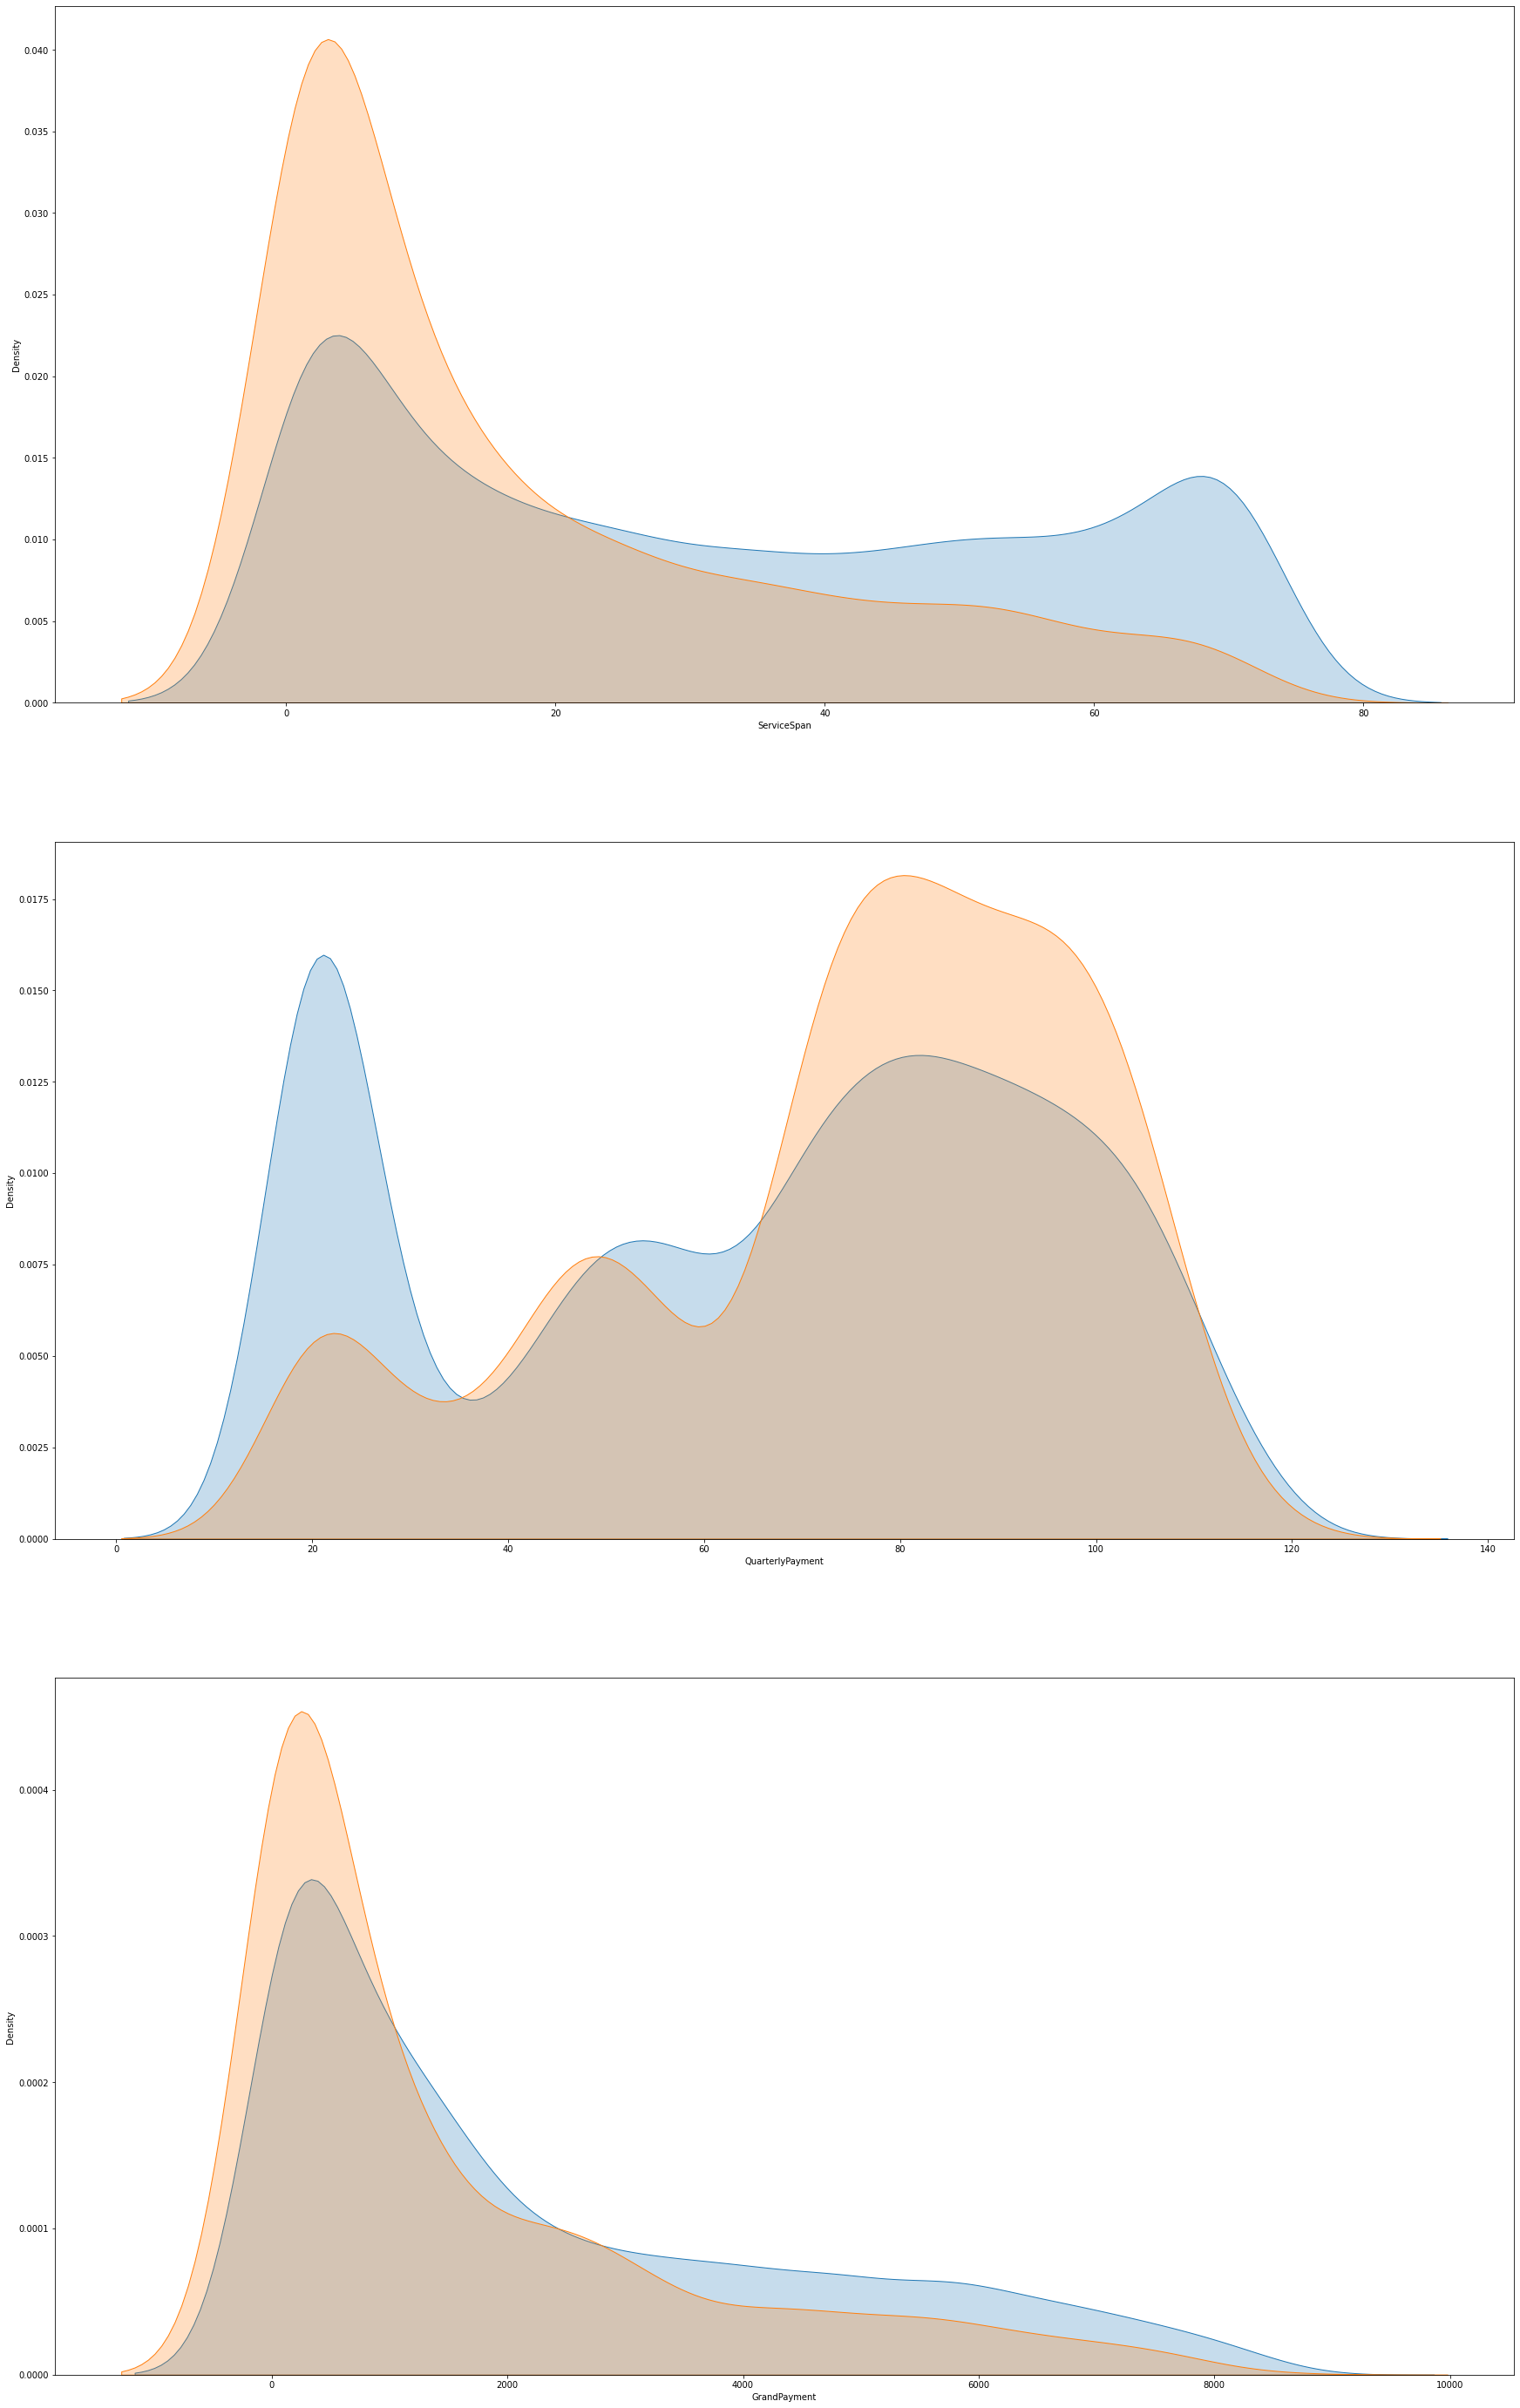

In [143]:
fig, ax = plt.subplots(len(cont_features), 1, figsize=(30, 50))

for (i,feature) in enumerate(cont_features):
    sns.kdeplot(data=train,  x=feature, ax=ax[i], shade=True, hue_order=prediction)
    sns.kdeplot(data=pos_train,  x=feature, ax=ax[i], shade=True, hue_order=prediction)
plt.show()

In [115]:
# X['NumSubscription']= X.apply(lambda x: 
#                                              (x['CyberProtection'] == "Yes") + 
#                                              (x['HardwareSupport'] == "Yes") + 
#                                              (x['TechnicalAssistance'] == "Yes") +
#                                              (x['FilmSubscription'] == "Yes"), axis=1)

# test['NumSubsription']= test.apply(lambda x: 
#                                              (x['CyberProtection'] == "Yes") + 
#                                              (x['HardwareSupport'] == "Yes") + 
#                                              (x['TechnicalAssistance'] == "Yes") +
#                                              (x['FilmSubscription'] == "Yes"), axis=1)

Create categorical bins for *quaterly payment* and *service span* features to bring out it's features more

In [144]:
range_labels = ['low', 'mid', 'high']
qp_bins = [0, 40, 60, 140]
sp_bins = [-2, 20, 60, 73]

X['QuarterlyPaymentRange'] = pd.cut(X['QuarterlyPayment'], bins=qp_bins, labels=range_labels)
test['QuarterlyPaymentRange'] = pd.cut(test['QuarterlyPayment'], bins=qp_bins, labels=range_labels)

X['ServiceSpanRange'] = pd.cut(X['ServiceSpan'], bins=sp_bins, labels=range_labels)
test['ServiceSpanRange'] = pd.cut(test['ServiceSpan'], bins=sp_bins, labels=range_labels)

cat_features.append('QuarterlyPaymentRange')
cat_features.append('ServiceSpanRange')

# Encode Data

In [145]:
#For categorical values
le = LabelEncoder()
y = le.fit_transform(y)

for cat_f in cat_features:
    #combine the train and test sets
    tot = X[cat_f].append(test[cat_f])
    le.fit(tot)
    X[cat_f] = le.transform(X[cat_f])
    test[cat_f] = le.transform(test[cat_f])

In [146]:
#For continous values
mm_scaler = MinMaxScaler()

tot = X[cont_features].append(test[cont_features])
mm_scaler.fit(tot)
X[cont_features] = mm_scaler.transform(X[cont_features])
test[cont_features] = mm_scaler.transform(test[cont_features])

In [148]:
#Display the final training dataset
X

,sex,Aged,Married,TotalDependents,ServiceSpan,MobileService,4GService,CyberProtection,HardwareSupport,TechnicalAssistance,FilmSubscription,SettlementProcess,QuarterlyPayment,GrandPayment,QuarterlyPaymentRange,ServiceSpanRange
ID,,,,,,,,,,,,,,,,
B60LHTZLLPFU4IULNPUF,0,0,0,1,0.662162,1,2,0,1,1,0,2,0.769898,0.531957,0,2
1RUJ7ONYZHYTWKOKO1SD,1,0,1,0,0.621622,1,2,0,0,0,1,0,0.024856,0.104479,1,2
DZ9EEOQWSN0MYCBUPAM5,1,1,1,0,0.810811,1,2,1,0,1,0,1,0.863831,0.713946,0,2
YZ43L1UQUQACTL1PXXZG,1,0,0,0,0.202703,1,2,0,0,0,0,2,0.614398,0.142148,0,1
6P28152QGF60PDLSCB9M,0,0,1,1,0.351351,1,2,0,1,0,1,2,0.339240,0.146377,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Y7U717HO87PCW6XXIQA1,0,1,0,0,0.054054,1,2,0,1,0,1,1,0.809679,0.049093,0,1
NGY3WOQ0OT1P4RHAR0PT,0,1,0,0,0.027027,1,1,0,0,0,1,0,0.274275,0.003346,2,1
ZBBW7H8AYLZJ2HK5TBBJ,1,0,0,1,0.256757,1,0,0,0,0,0,3,0.189159,0.061812,1,1


# Train-Test Split

In [119]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, random_state = 10, test_size = 0.2, shuffle=True, stratify=y)

# Sampling
As it is evident from the profile data, ther a class difference (more negative attrition are there than positive counterparts). Hence we oversample the data to create more positive data.

In [172]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

# define resampling
over = RandomOverSampler(sampling_strategy=0.5)
under = RandomUnderSampler(sampling_strategy=0.6)

# define pipeline for oversampling and undersampling
pipeline = Pipeline(steps=[('o', over), ('u', under)])

X_sampled, y_sampled = pipeline.fit_resample(X_temp, y_temp)

In [173]:
print("Before sampling total training data:", X_temp.shape)
print("After sampling total training data:", X_sampled.shape)

Before sampling total training data: (5062, 16)
After sampling total training data: (4957, 16)


# View the Class Distribution before and after Sampling

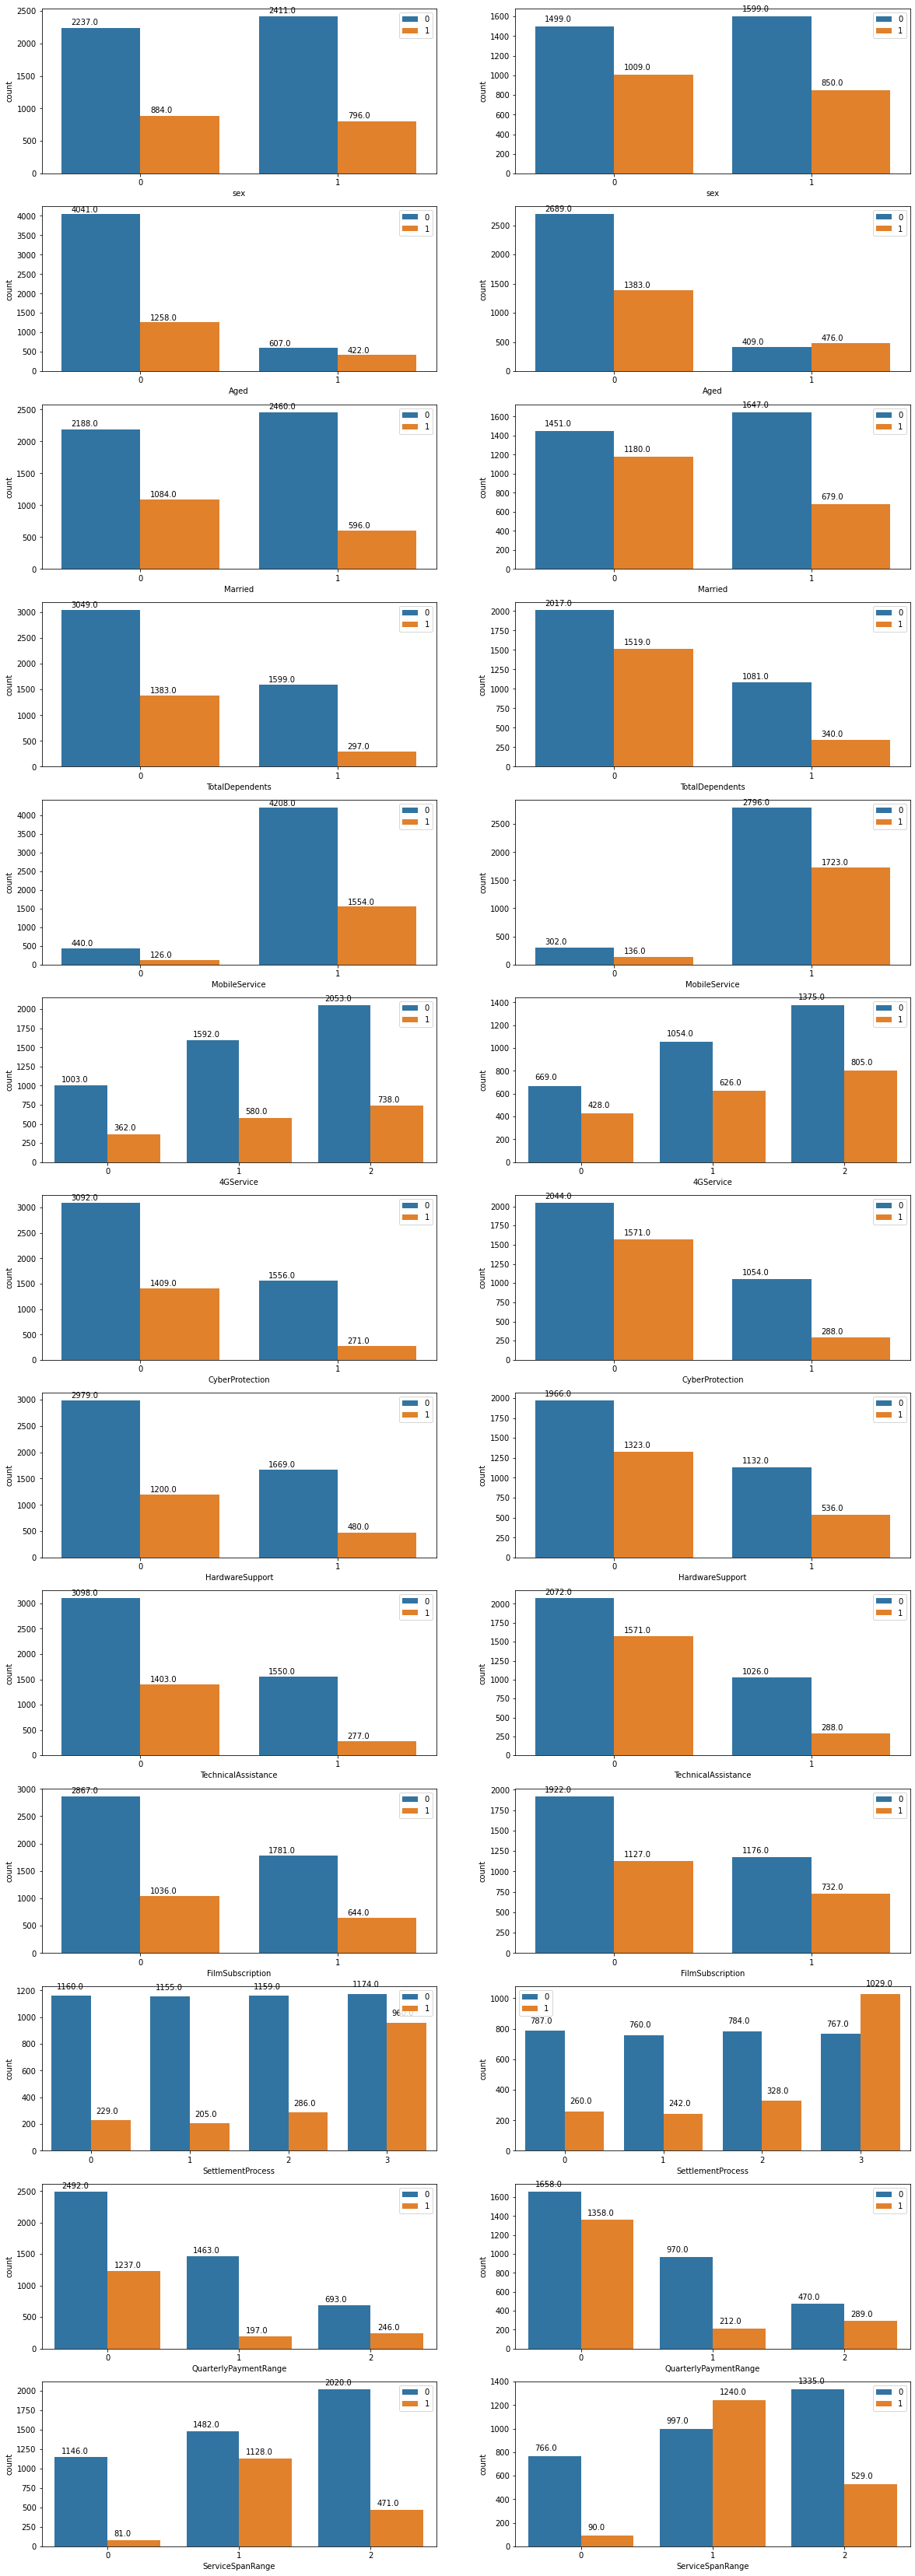

In [122]:
fig, ax = plt.subplots(len(cat_features), 2, figsize=(20, 60))

for (i,feature) in enumerate(cat_features):
    
    #Before Resampling
    sns.countplot(x=feature, hue=y, ax=ax[i][0], data=X)
    
    #After Resampling
    sns.countplot(x=feature, hue=y_sampled, ax=ax[i][1], data=X_sampled)
    
    for p in ax[i][1].patches:
        ax[i][1].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+50))
        
    for p in ax[i][0].patches:
        ax[i][0].annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.05, p.get_height()+50))

In [123]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV

#RepeatedStratified KFold Cross Validation for various probability grouping based on the argument proba 
def eval_model(model, proba = 0.5):
    cv_rep = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=1)
    count = 0
    
    avg_accuracy = [0] * 2
    avg_recall = [0] * 2
    avg_precision = [0] * 2
    avg_f1_score = [0] * 2
    num_splits = cv_rep.get_n_splits()
    
    print("Total Splits:", num_splits)
    
    for train_index, val_index in cv_rep.split(X_sampled, y_sampled):
        
        print('\nKFold Cross-Validation {}/{}'.format(count+1,cv_rep.get_n_splits()))
        X_cv_train, y_cv_train = X_sampled.loc[train_index], y_sampled[train_index]
        X_cv_val, y_cv_val = X_sampled.loc[val_index], y_sampled[val_index]
        
        model.fit(X_cv_train,y_cv_train)
        
#         y_pred_train = np.where(model.predict_proba(X_cv_train)[:,1] >= proba, 1, 0)        
#         print("\nTrain: \n", (classification_report(y_cv_train, y_pred_train)))
#         cm = confusion_matrix(y_cv_train, y_pred_train)
#         print(cm)
        
        y_pred_val = np.where(model.predict_proba(X_cv_val)[:,1] >= proba, 1, 0)
        print("\nVal: \n", (classification_report(y_cv_val, y_pred_val)))
        cm = confusion_matrix(y_cv_val, y_pred_val)
        print(cm)
        avg_accuracy[0] += accuracy_score(y_cv_val, y_pred_val)
        avg_recall[0] += recall_score(y_cv_val, y_pred_val, average=None)
        avg_precision[0] += precision_score(y_cv_val, y_pred_val, average=None)
        avg_f1_score[0] += f1_score(y_cv_val, y_pred_val, average='weighted')
        
        y_pred_test = np.where(model.predict_proba(X_test)[:,1] >= proba, 1, 0)
        print("\nTest: \n", (classification_report(y_test, y_pred_test)))
        cm = confusion_matrix(y_test, y_pred_test)
        print(cm)
        avg_accuracy[1] += accuracy_score(y_test, y_pred_test)
        avg_recall[1] += recall_score(y_test, y_pred_test, average=None)
        avg_precision[1] += precision_score(y_test, y_pred_test, average=None)
        avg_f1_score[1] += f1_score(y_test, y_pred_test, average='weighted')

        count += 1
        
    print("\nValidation Set Classification Report: Average of {} CVs".format(num_splits))
    print("Accuracy:", avg_accuracy[0]/num_splits)
    print("Recall:", avg_recall[0]/num_splits)
    print("Precision:", avg_precision[0]/num_splits)
    print("f1-score:", avg_f1_score[0]/num_splits)
    
    print("\nTest Set Classification Report: Average of {} CVs".format(num_splits))
    print("Accuracy:", avg_accuracy[1]/num_splits)
    print("Recall:", avg_recall[1]/num_splits)
    print("Precision:", avg_precision[1]/num_splits)
    print("f1-score:", avg_f1_score[1]/num_splits)
    

#Used to fine tune the model with the given parameters
def grid_search(model, parameters):
    grid_search = GridSearchCV(estimator = model, param_grid = parameters,scoring = 'accuracy',cv = 5, n_jobs=-1, verbose=5)
    grid_search = grid_search.fit(X_sampled, y_sampled)
    print(grid_search.best_params_)
    print(grid_search.best_score_)

# Fine Tune Basic Models with Hyperparameter Search
Most models perform about the same with different hyperparameters hence, the no fine tuning is done

In [124]:
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier()
parameters = [{
          'n_estimators' : [250,300],
          'criterion': ['entropy', 'gini'],
          'max_features': ['auto', 'log2']
          }]
# grid_search(random, parameters)
# eval_model(clf1)

In [132]:
from sklearn.ensemble import RandomForestClassifier
random = RandomForestClassifier()
eval_model(random)

Total Splits: 10

KFold Cross-Validation 1/10

Val: 
               precision    recall  f1-score   support

           0       0.84      0.83      0.84       620
           1       0.73      0.74      0.73       372

    accuracy                           0.80       992
   macro avg       0.78      0.79      0.79       992
weighted avg       0.80      0.80      0.80       992

[[515 105]
 [ 95 277]]

Test: 
               precision    recall  f1-score   support

           0       0.85      0.85      0.85       930
           1       0.58      0.58      0.58       336

    accuracy                           0.78      1266
   macro avg       0.71      0.71      0.71      1266
weighted avg       0.78      0.78      0.78      1266

[[790 140]
 [142 194]]

KFold Cross-Validation 2/10

Val: 
               precision    recall  f1-score   support

           0       0.86      0.86      0.86       620
           1       0.77      0.76      0.76       372

    accuracy                        

In [53]:
from imblearn.ensemble import BalancedRandomForestClassifier
brf = BalancedRandomForestClassifier()
eval_model(brf)

Total Splits: 10

KFold Cross-Validation 1/10

Val: 
               precision    recall  f1-score   support

           0       0.88      0.75      0.81       620
           1       0.67      0.83      0.74       372

    accuracy                           0.78       992
   macro avg       0.77      0.79      0.77       992
weighted avg       0.80      0.78      0.78       992

[[467 153]
 [ 65 307]]

Test: 
               precision    recall  f1-score   support

           0       0.89      0.74      0.81       930
           1       0.51      0.75      0.61       336

    accuracy                           0.74      1266
   macro avg       0.70      0.75      0.71      1266
weighted avg       0.79      0.74      0.76      1266

[[689 241]
 [ 83 253]]

KFold Cross-Validation 2/10

Val: 
               precision    recall  f1-score   support

           0       0.88      0.74      0.80       620
           1       0.66      0.83      0.73       372

    accuracy                        

In [54]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier()
eval_model(etc)

Total Splits: 10

KFold Cross-Validation 1/10

Val: 
               precision    recall  f1-score   support

           0       0.83      0.85      0.84       620
           1       0.74      0.70      0.72       372

    accuracy                           0.80       992
   macro avg       0.78      0.78      0.78       992
weighted avg       0.79      0.80      0.80       992

[[529  91]
 [111 261]]

Test: 
               precision    recall  f1-score   support

           0       0.84      0.85      0.84       930
           1       0.57      0.54      0.56       336

    accuracy                           0.77      1266
   macro avg       0.70      0.70      0.70      1266
weighted avg       0.77      0.77      0.77      1266

[[791 139]
 [153 183]]

KFold Cross-Validation 2/10

Val: 
               precision    recall  f1-score   support

           0       0.85      0.84      0.85       620
           1       0.74      0.76      0.75       372

    accuracy                        

In [126]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
stack2 = StackingClassifier(estimators=[('randomforest', random), ('extratree', etc), ('bal_randomforest', brf)], final_estimator=LogisticRegression())
eval_model(stack2)

Total Splits: 10

KFold Cross-Validation 1/10

Val: 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       620
           1       0.76      0.70      0.73       372

    accuracy                           0.80       992
   macro avg       0.79      0.78      0.79       992
weighted avg       0.80      0.80      0.80       992

[[537  83]
 [111 261]]

Test: 
               precision    recall  f1-score   support

           0       0.83      0.87      0.85       930
           1       0.60      0.51      0.55       336

    accuracy                           0.78      1266
   macro avg       0.71      0.69      0.70      1266
weighted avg       0.77      0.78      0.77      1266

[[813 117]
 [163 173]]

KFold Cross-Validation 2/10

Val: 
               precision    recall  f1-score   support

           0       0.84      0.88      0.86       620
           1       0.79      0.73      0.76       372

    accuracy                        

# Exporting the Prediction

In [163]:
stack2.fit(X_sampled, y_sampled)
y_pred = np.where(stack2.predict_proba(test)[:,1] >= 0.48, 1, 0 )
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [164]:
y_pred = pd.DataFrame({'CustomerAttrition': y_pred})['CustomerAttrition'].map({1:'Yes', 0:'No'})

In [165]:
y_pred.value_counts()

No     560
Yes    145
Name: CustomerAttrition, dtype: int64

In [166]:
output = pd.DataFrame({'ID': test.index, 'CustomerAttrition': y_pred})
output.to_csv('stack-sampled-classifier.csv', index=False)

In [167]:
comp_pred = pd.read_csv('../input/submission-comparision/target1.csv', index_col="ID")
len(np.where(comp_pred['CustomerAttrition'].to_numpy() != output['CustomerAttrition'].to_numpy())[0])

55